In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,log_loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report

In [62]:
class LogisticRegressionGD:

    def __init__(self, learning_rate=0.01, n_iterations=1000, 
                 tolerance=1e-6, momentum=0.9, verbose=False):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.tolerance = tolerance
        self.momentum = momentum
        self.verbose = verbose
        self.weights = None
        self.bias = None
        self.train_loss_history = []
        self.val_loss_history = []
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))  
    
    def compute_gradient(self, X, y):
        m = X.shape[0]
        
        y_pred = self.sigmoid(np.dot(X, self.weights) + self.bias)
        
        dw = (1/m) * np.dot(X.T, (y_pred - y))
        db = (1/m) * np.sum(y_pred - y)
        
        loss = -np.mean(y * np.log(y_pred + 1e-15) + (1 - y) * np.log(1 - y_pred + 1e-15))
        
        return dw, db, loss
    
    def predict_proba(self, X):
        return self.sigmoid(np.dot(X, self.weights) + self.bias)
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        n_features = X_train.shape[1]
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        v_w = np.zeros_like(self.weights)
        v_b = 0
        
        for i in range(self.n_iterations):
            dw, db, train_loss = self.compute_gradient(X_train, y_train)
            self.train_loss_history.append(train_loss)
            
            if X_val is not None and y_val is not None:
                val_pred = self.predict_proba(X_val)
                val_loss = -np.mean(y_val * np.log(val_pred + 1e-15) + 
                                   (1 - y_val) * np.log(1 - val_pred + 1e-15))
                self.val_loss_history.append(val_loss)
            
            v_w = self.momentum * v_w - self.learning_rate * dw
            v_b = self.momentum * v_b - self.learning_rate * db
            
            self.weights += v_w
            self.bias += v_b
            
            if self.verbose and (i % 100 == 0 or i == self.n_iterations - 1):
                train_acc = accuracy_score(y_train, self.predict(X_train))
                print(f"Iteration {i}: train_loss = {train_loss:.6f}, train_acc = {train_acc:.4f}", end="")
                
                if X_val is not None and y_val is not None:
                    val_acc = accuracy_score(y_val, self.predict(X_val))
                    print(f", val_loss = {val_loss:.6f}, val_acc = {val_acc:.4f}", end="")
                print()
            
            gradient_norm = np.linalg.norm(dw) + abs(db)
            if gradient_norm < self.tolerance:
                if self.verbose:
                    print(f"Converged after {i+1} iterations!")
                break
        
        return self
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        accuracy = accuracy_score(y, y_pred)
        y_pred_proba = self.predict_proba(X)
        loss = log_loss(y, y_pred_proba)
        
        return {
            'accuracy': accuracy,
            'log_loss': loss
        }
    
    def plot_training_history(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_loss_history, label='Training Loss')
        
        if self.val_loss_history:
            plt.plot(self.val_loss_history, label='Validation Loss')
            
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Training History')
        plt.legend()
        plt.grid(True)
        plt.show()

In [66]:
def plot_decision_boundary(X, y, model, scaler=None):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    if scaler:
        grid_points = scaler.transform(grid_points)
    
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.colorbar()
    plt.show()


In [67]:
def gradient_descent(gradient_func, initial_params, learning_rate=0.01, n_iterations=100, 
                     tolerance=1e-6, momentum=0.9, verbose=True):
    
    params = np.array(initial_params, dtype=float)
    param_history = [params.copy()]
    cost_history = []
    velocity = np.zeros_like(params)
    
    for i in range(n_iterations):
        gradient, cost = gradient_func(params)
        cost_history.append(cost)
        
        velocity = momentum * velocity - learning_rate * gradient
        
        params = params + velocity
        param_history.append(params.copy())
        
        gradient_norm = np.linalg.norm(gradient)
        if verbose and (i % 10 == 0 or i == n_iterations - 1):
            print(f"Iteration {i}: cost = {cost:.6f}, gradient norm = {gradient_norm:.6f}")
        
        if gradient_norm < tolerance:
            if verbose:
                print(f"Converged after {i+1} iterations!")
            break
    
    return params, param_history, cost_history

In [68]:
def quadratic_gradient(params):
    x, y = params
    gradient = np.array([2*x, 4*y])
    cost = x**2 + 2*y**2
    return gradient, cost

In [69]:
def loss_function(params):
    return np.sum((y - (params[0] * X + params[1]))**2)  

In [70]:
data=pd.read_csv("pima_diabetes_featured.csv")

In [71]:
data.shape

(662, 17)

In [72]:
data.columns

Index(['Pregnancies', 'Glucose', 'SkinThickness', 'BMI', 'BloodPressure',
       'Insulin', 'DiabetesPedigreeFunction', 'Age', 'Outcome',
       'Pregnancies_yeojohnson', 'Glucose_boxcox', 'SkinThickness_boxcox',
       'BMI_boxcox', 'BloodPressure_boxcox', 'Insulin_boxcox',
       'DiabetesPedigreeFunction_yeojohnson', 'Age_yeojohnson'],
      dtype='object')

In [73]:
X = data[['Pregnancies_yeojohnson', 'Glucose_boxcox', 'SkinThickness_boxcox',
          'BMI_boxcox', 'BloodPressure_boxcox', 'Insulin_boxcox',
          'DiabetesPedigreeFunction_yeojohnson', 'Age_yeojohnson']].values
y = data['Outcome'].values

model = RandomForestClassifier(n_estimators=100, random_state=42)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')

print("Stratified K-Fold Accuracy Scores:", scores)
print("Mean Accuracy:", scores.mean())

Stratified K-Fold Accuracy Scores: [0.84210526 0.78947368 0.75757576 0.78787879 0.86363636]
Mean Accuracy: 0.8081339712918659


In [74]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
scores = cross_val_score(model, X, y, cv=rkf, scoring='accuracy')

print("Repeated K-Fold Accuracy Scores:", scores)
print("Mean Accuracy:", scores.mean())


Repeated K-Fold Accuracy Scores: [0.84210526 0.81203008 0.81060606 0.84848485 0.79545455 0.82706767
 0.78947368 0.86363636 0.8030303  0.82575758 0.83458647 0.83458647
 0.8030303  0.84848485 0.77272727]
Mean Accuracy: 0.8207374496848181


Iteration 0: train_loss = 0.693147, train_acc = 0.7637, val_loss = 0.693147, val_acc = 0.7830
Iteration 100: train_loss = 0.481504, train_acc = 0.7732, val_loss = 0.443048, val_acc = 0.7736
Iteration 200: train_loss = 0.481502, train_acc = 0.7732, val_loss = 0.442927, val_acc = 0.7736
Converged after 236 iterations!

Test Metrics:
accuracy: 0.8148
log_loss: 0.4287


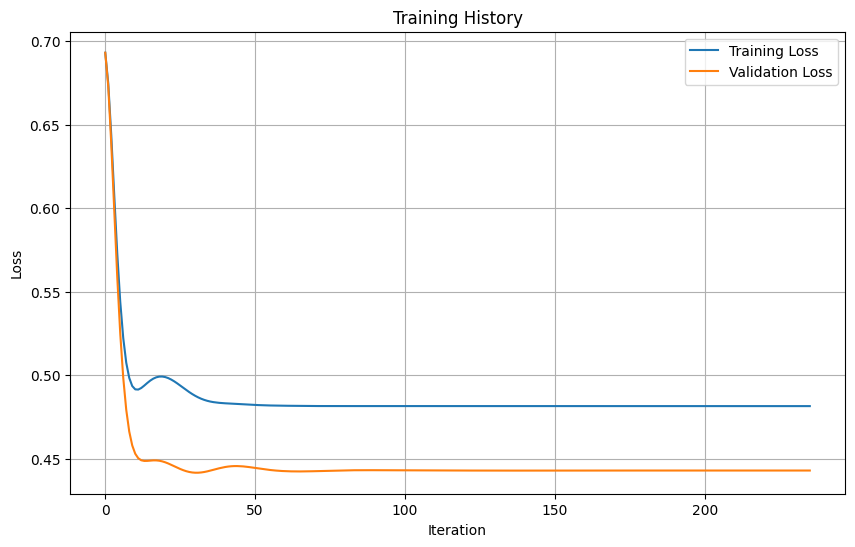

In [75]:
X = data[['Pregnancies_yeojohnson', 'Glucose_boxcox', 'SkinThickness_boxcox',
        'BMI_boxcox', 'BloodPressure_boxcox', 'Insulin_boxcox',
        'DiabetesPedigreeFunction_yeojohnson', 'Age_yeojohnson']]
y = data['Outcome']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegressionGD(learning_rate=0.1, n_iterations=1000, 
                            momentum=0.9, verbose=True)
model.fit(X_train_scaled, y_train, X_val_scaled, y_val)

test_metrics = model.evaluate(X_test_scaled, y_test)
print("\nTest Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

model.plot_training_history()

if X.shape[1] == 2:  
    plot_decision_boundary(X, y, model, scaler)

Iteration 0: cost = 1.000000, gradient norm = 2.000000
Iteration 10: cost = 0.000019, gradient norm = 0.008800
Iteration 20: cost = 0.121977, gradient norm = 0.698505
Iteration 30: cost = 0.001940, gradient norm = 0.088086
Iteration 40: cost = 0.013463, gradient norm = 0.232059
Iteration 49: cost = 0.003539, gradient norm = 0.118974


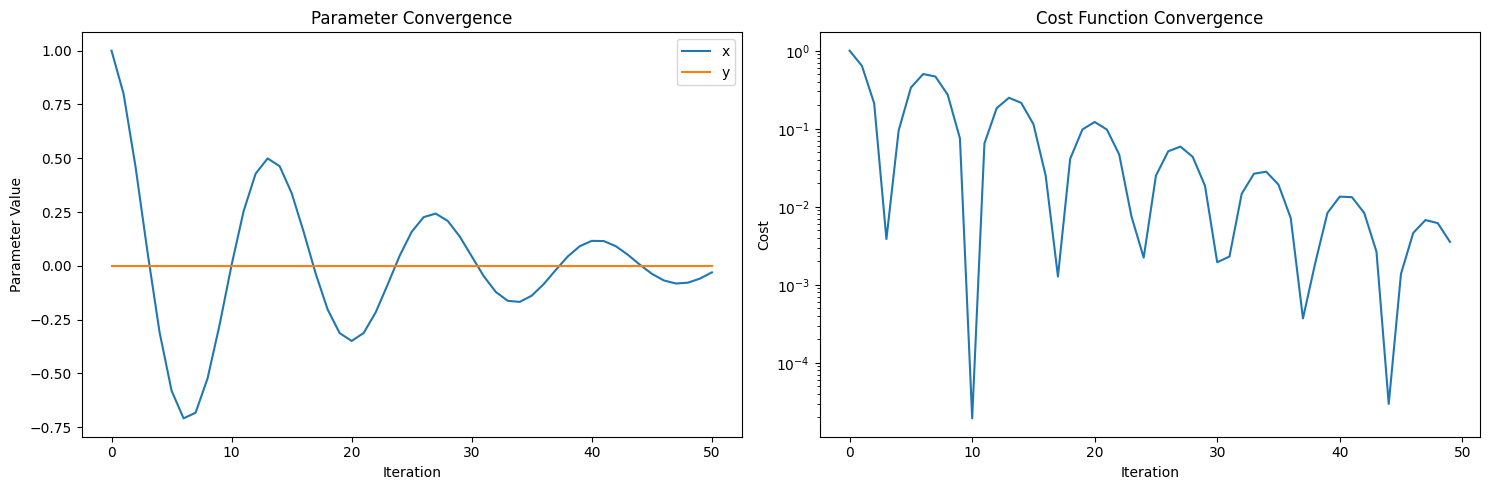

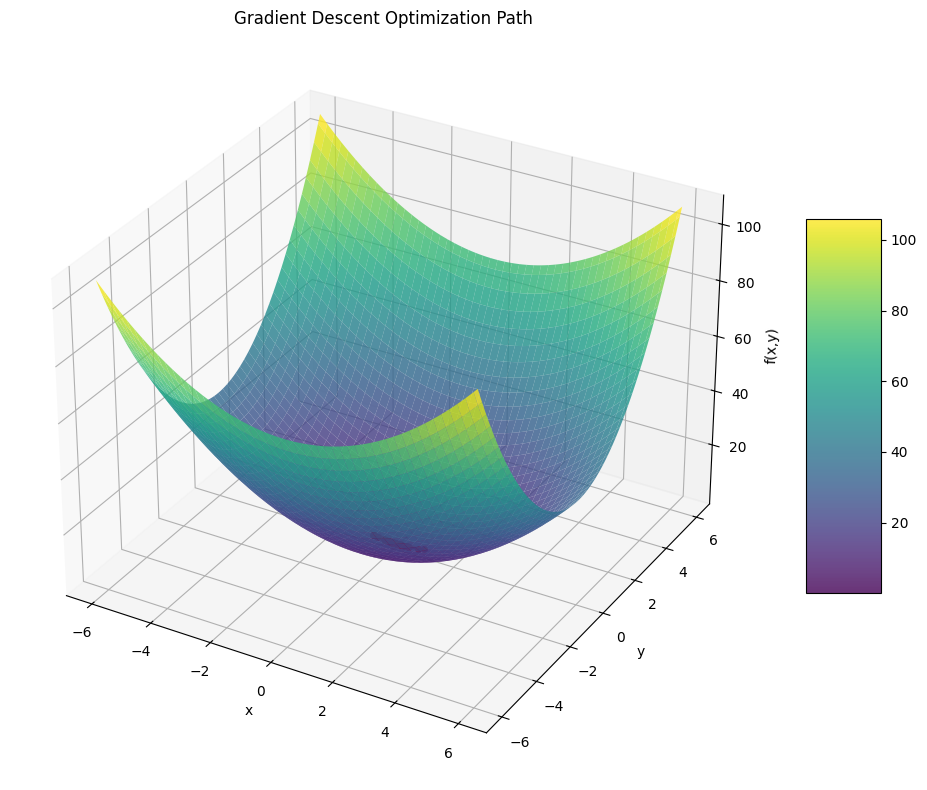

In [77]:
initial_params = [9.99999995e-01 , 7.97816338e-09]
optimal_params, param_history, cost_history = gradient_descent(
    quadratic_gradient, initial_params, learning_rate=0.1, n_iterations=50
)

param_history = np.array(param_history)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(param_history[:, 0], label='x')
plt.plot(param_history[:, 1], label='y')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.title('Parameter Convergence')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cost_history)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost Function Convergence')
plt.yscale('log')

plt.tight_layout()
plt.show()

from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(-6, 6, 100)
y = np.linspace(-6, 6, 100)
X, Y = np.meshgrid(x, y)
Z = X**2 + 2*Y**2  

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surface = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, linewidth=0)

ax.plot(param_history[:, 0], param_history[:, 1], 
        [quadratic_gradient([p[0], p[1]])[1] for p in param_history], 
        'r-', linewidth=2, marker='o', markersize=4)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
ax.set_title('Gradient Descent Optimization Path')

fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()